In [9]:
import pandas as pd

# Cargar el archivo CSV en un DataFrame
df_data = pd.read_csv('complaints.csv')

# Mostrar las primeras filas del DataFrame para verificar el contenido
print(df_data.head())


C:\Users\gigim\AppData\Local\Temp\ipykernel_8584\3434250453.py:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv('complaints.csv')


  Date received                                            Product  \
0    2024-10-17  Credit reporting or other personal consumer re...   
1    2024-10-17  Credit reporting or other personal consumer re...   
2    2024-10-17  Credit reporting or other personal consumer re...   
3    2024-10-17  Credit reporting or other personal consumer re...   
4    2024-10-17  Credit reporting or other personal consumer re...   

        Sub-product                                              Issue  \
0  Credit reporting               Incorrect information on your report   
1  Credit reporting               Incorrect information on your report   
2  Credit reporting               Incorrect information on your report   
3  Credit reporting               Incorrect information on your report   
4  Credit reporting  Problem with a company's investigation into an...   

                              Sub-issue Consumer complaint narrative  \
0         Account information incorrect                       

In [12]:
df_filtered = df_data.dropna(subset=['Consumer complaint narrative'])
# Mostrar las filas con texto en 'Consumer complaint narrative'
textual_data = df_data[df_data['Consumer complaint narrative'].notna()]
df_filtered_1 = df_filtered.sample(n=5000, random_state=42)

# Mostrar las primeras filas de esa columna con texto
print("\nAlgunas filas de 'Consumer complaint narrative' con texto:")
print(textual_data['Consumer complaint narrative'].head())

# Contar el total de filas con texto y el total de filas del DataFrame
num_texts = df_filtered_1.shape[0]
total_rows = df_data.shape[0]

# Imprimir los resultados
print(f"\nNúmero de filas con texto en 'Consumer complaint narrative': {num_texts}")
print(f"Total de filas en el DataFrame: {total_rows}")


Algunas filas de 'Consumer complaint narrative' con texto:
406    This agency is violating your consumer rights ...
483    I made a purchase, order # XXXX, from XXXX XXX...
544    You are in violation of 15 USC 1681s- ( 2 ) ( ...
565    Subject : TransUnion 's Violation of the Fair ...
582    I am writing to address the ongoing inaccuraci...
Name: Consumer complaint narrative, dtype: object

Número de filas con texto en 'Consumer complaint narrative': 5000
Total de filas en el DataFrame: 6486747


In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import nltk
import nltk
# Descargar recursos necesarios para nltk 
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Función para preprocesar el texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Eliminar stopwords en inglés 
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lematizar 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Calcular el número de instancias por clase
class_counts = df_filtered_1['Product'].value_counts()

# Definir un umbral mínimo de instancias por clase 
min_samples = 200

# Filtrar las filas cuyo 'Product' tenga al menos el número mínimo de instancias
df_filtered_1 = df_filtered_1[df_filtered_1['Product'].isin(class_counts[class_counts >= min_samples].index)]


# Aplicar el preprocesamiento a la columna 'Consumer complaint narrative'
df_filtered_1['processed_text'] = df_filtered_1['Consumer complaint narrative'].apply(preprocess_text)

# Mostrar algunas filas del texto 
print(df_filtered_1[['Consumer complaint narrative', 'processed_text']].head())

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                              Consumer complaint narrative  \
2843302  I filed a dispute for incorrect information on...   
816632   In the quiet humdrum of everyday life, a sudde...   
572851   In accordance with the Fair Credit Reporting A...   
3388965  In accordance with the Fair Credit Reporting a...   
3110399  I have tried on numerous occasions to get Lexi...   

                                            processed_text  
2843302  filed dispute incorrect information credit rep...  
816632   quiet humdrum everyday life sudden jolt shatte...  
572851   accordance fair credit reporting act account x...  
3388965  accordance fair credit reporting act list acco...  
3110399  tried numerous occasion get lexis nexis remove...  


In [14]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import classification_report, accuracy_score, f1_score
from datasets import Dataset
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Cargar y preparar los datos
# Usamos el subconjunto filtrado de 10,000 datos procesados y con clases balanceadas
df = df_filtered_1[['processed_text', 'Product']].copy()

# Codificar las etiquetas en valores numéricos
df['label'] = df['Product'].factorize()[0]
label_mapping = dict(zip(df['Product'].factorize()[1], range(df['Product'].nunique())))

# Dividir en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 2. Convertir DataFrame en un formato Dataset para Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 3. Tokenizar los datos
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(example):
    return tokenizer(example["processed_text"], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# 4. Configuración del modelo y entrenamiento
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_mapping))

# Definir el collator para aplicar padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Definir métrica de evaluación
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": accuracy, "f1": f1}

# Configurar los parámetros de entrenamiento (sin fp16)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,  # Reducir el batch size si se necesita
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=False  # Desactivar fp16 si no se usa GPU
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 5. Entrenar el modelo
trainer.train()

# 6. Evaluar el modelo en el conjunto de prueba
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
print(classification_report(test_df['label'], preds, target_names=label_mapping.keys()))


Map:   0%|          | 0/3508 [00:00<?, ? examples/s]

Map:   0%|          | 0/878 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.292300,1.099006,0.493166,0.440527
2,0.997300,1.005201,0.589977,0.544304
3,0.806900,0.980859,0.657175,0.649211


                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.68      0.76      0.72       347
                         Credit reporting or other personal consumer reports       0.65      0.57      0.61       249
                                                 Checking or savings account       0.75      0.51      0.61        41
                                                             Debt collection       0.71      0.72      0.71       120
                                                                    Mortgage       0.55      0.76      0.64        67
                                                 Credit card or prepaid card       0.44      0.22      0.30        54

                                                                    accuracy                           0.66       878
                                                      

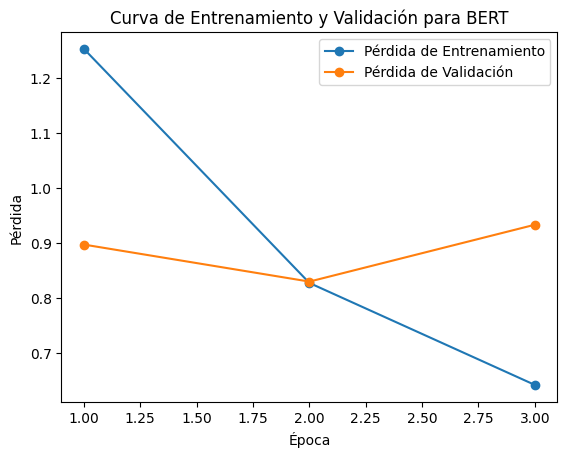

In [17]:
import matplotlib.pyplot as plt
# Suponiendo que tienes acceso a los valores de pérdida y exactitud de cada época
epochs = [1, 2, 3]  # o el número de épocas que hayas usado
training_loss = [1.2533, 0.8277, 0.6423]  # valores de ejemplo
validation_loss = [0.8975, 0.8302, 0.9336]

# Gráfico de la pérdida
plt.plot(epochs, training_loss, label="Pérdida de Entrenamiento", marker='o')
plt.plot(epochs, validation_loss, label="Pérdida de Validación", marker='o')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Curva de Entrenamiento y Validación para BERT")
plt.legend()
plt.show()